# AlphaFold Predicted Aligned Error (PAE) Visualization

This Jupyter Notebook  designed to process and visualize Predicted Aligned Error (PAE) matrices from AlphaFold predictions. PAE matrices provide valuable insights into the confidence of predicted residue-residue distances in protein structures.

# Contents

This notebook includes code for handling AlphaFold Predicted Aligned Error (PAE) data. It defines classes and functions to load PAE data from pickle files, generate PAE plots, and save the results. Custom color mapping and selection of specific matrix parts are supported.

# Dependencies

- Python 3.x
- pickle
- NumPy
- Pandas
- Matplotlib
- BioPython

# Usage

- Import Modules: Run the first cell to import the necessary modules and define classes and functions.
- Set Paths and Files: Set the working directory to the location containing the PAE file. These paths should be adapted based on the Zenodo archive where the data is stored: (e.g., Data/Analyse/PEA/dimer.pkl).
- Select Matrix Parts: Define the parts of the PAE matrix you want to select and visualize.
- Generate and Save Plots: Execute the notebook to generate the PAE plots and save them as images.

# Acknowledgements

This code is based on AlphaPickle and has been adapted to work with specific data sets. If you utilize or adapt this code, please cite the original work:

Arnold, M. J. (2021) AlphaPickle. doi.org/10.5281/zenodo.5708709

# Author

Sujith Sritharan

In [8]:
#@title Import modules and define classes and functions
#@markdown Please run this cell first to prepare the python environment.
import sys
import pickle as pkl
#from zipfile import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt ,colors as cols ,cm as cm
import json
from sys import exit
import os
from Bio import PDB as pdb 
import io
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:

# Define class for AlphaFold metadata file and class methods
class AlphaFoldMetaData(object):
    def __init__(self, PathToFile, FastaSequence=None, ranking=None):
        # Define attributes
        self.PathToFile = PathToFile
        self.FastaSequence = FastaSequence
        self.saving_filename = self.PathToFile.split("/")[-1].split(".")[0]
        self.saving_pathname = self.PathToFile.split(self.saving_filename)[0]
        if ranking:
            self.saving_filename = "ranked_{}".format(ranking)

        # Generate a plot from PAE measurements
    def plot_PAE(self, size_in_inches=12, axis_label_increment=100):
        ticks = np.arange(0, self.PAE[1].size, axis_label_increment)
        plt.figure(figsize=(size_in_inches,size_in_inches))
        
        colors = ["blue", "lightblue", "yellow", "orange", "grey", "lightgrey", "white"]
        values = [0, 5, 10, 15, 20, 25, 30]
        # Normalize the values to range between 0 and 1
        normalized_values = [v / 30 for v in values]
        colormap = mcolors.LinearSegmentedColormap.from_list("", list(zip(normalized_values, colors)))
        PAE = plt.imshow(self.PAE, cmap=colormap, vmin=0, vmax=30,origin='lower')
        
        plt.xticks(ticks, fontname="Helvetica")
        plt.xticks(ticks, rotation=90, fontname="Helvetica")
        plt.yticks(ticks, fontname="Helvetica")
        plt.xlabel("Residue index", size=14, fontweight="bold", fontname="Helvetica")
        plt.ylabel("Residue index", size=14, fontweight="bold", fontname="Helvetica")
        scale = plt.colorbar(PAE, shrink=0.5)
        scale.set_label(label="Predicted error (Å)",size=12, fontweight="bold", fontname="Helvetica")
        
        # Save plot
        plt.savefig('{}/{}_PAE.png'.format(self.saving_pathname, self.saving_filename),dpi=300)

        # Generate dataframe from PAE data and save to csv
        pd_PAE = pd.DataFrame(self.PAE)
        pd_PAE.to_csv('{}/{}_PAE.csv'.format(self.saving_pathname, self.saving_filename))


class AlphaFoldPickle(AlphaFoldMetaData):

    def __init__(self, PathToFile, FastaSequence=None, ranking=None):
        super().__init__(PathToFile, FastaSequence, ranking)        # Define attributes
        if ranking:
            self.saving_filename = "ranked_{}".format(ranking)
        self.data = []
        self.PAE = None

        # Extract pickled data
        with (open("{}".format(self.PathToFile), "rb")) as openfile:
            while True:
                try:
                    self.data.append(pkl.load(openfile))
                except EOFError:
                    break

        # Try statement accounts for data run using non-pTM models, with no PAE output
        try:
            self.PAE = self.data[0]['predicted_aligned_error']
        except:
            print("PAE model data not present. To access this performance metric, run AlphaFold"
            "using pTM-enabled models.")

        # Define pLDDT
        self.pLDDT = self.data[0]['plddt']





class AlphaFoldJson:
    def __init__(self, PathToDirectory):
        self.PathToDirectory = PathToDirectory
        self.RankingDebug = []
        try:
            with open("{}/ranking_debug.json".format(self.PathToDirectory)) as jsonfile:
                self.RankingDebugRaw = json.load(jsonfile)
            for index in enumerate(self.RankingDebugRaw['order']):
                self.RankingDebug.append(index)
        except:
            exit("To use batch processing, please ensure that the ranking_debug.json file and the result_model_n.pkl files are present in the directory issued in the command. Exiting AlphaPickle now...")


class AlphaFoldPDB(AlphaFoldMetaData):
    def loadCleanStructure(self,  id, filePath):
        standardResidues = ["ALA","ARG","ASN","ASP","CYS","GLU","GLN","GLY","HIS","ILE","LEU","LYS","MET","PHE","PRO","SER","THR","TRP","TYR","VAL"]

        parser = pdb.PDBParser()
        parsedStructure = parser.get_structure(id, filePath)
        for chain in parsedStructure.get_chains():
            removeResidues = list()
            for i, residue in enumerate(chain.get_residues()):
                if residue.resname not in standardResidues:
                    removeResidues.append(residue.id)
                    print(residue.id)
            [chain.detach_child(id) for id in removeResidues]
    
        return parsedStructure


            
class AlphaFoldPAEJson(AlphaFoldMetaData):
    def extractPAEfromJson(self, PathToFile):
        
        with open(PathToFile, 'r') as file:
            jsonstring = json.load(file)
            if 'predicted_aligned_error' in jsonstring[0]:
                pae = jsonstring[0]['predicted_aligned_error']
            else:
                residue1 = jsonstring[0]['residue1']
                residue2 = jsonstring[0]['residue2']
                pae = jsonstring[0]['distance']


        if 'predicted_aligned_error' in jsonstring[0]:
            paeArray = np.array(pae)
        else:
            paeArray = np.ones((max(residue1),(max(residue2))))
            for i, j, n in zip(residue1,residue2,pae):
                paeArray[int(i-1),int(j-1)] = n


        return paeArray
    

    def __init__(self, PathToFile, FastaSequence=None, ranking=None):
        super().__init__(PathToFile,FastaSequence,ranking)
        if ranking:
            self.saving_filename = "ranked_{}".format(ranking)

        self.PAE = self.extractPAEfromJson(PathToFile)
        self.pLDDT = None
    

In [4]:


def plot_PAE(self, size_in_inches=12, axis_label_increment=100):
    ticks = np.arange(0, self.PAE.shape[0], axis_label_increment)
    plt.figure(figsize=size_in_inches)


    
    colors = ["blue", "lightblue", "yellow", "orange", "grey", "lightgrey", "white"]
    values = [0, 5, 10, 15, 20, 25, 30]
    # Normalize the values to range between 0 and 1
    normalized_values = [v / 30 for v in values]
    colormap = mcolors.LinearSegmentedColormap.from_list("", list(zip(normalized_values, colors)))
    
    PAE = plt.imshow(self.PAE, cmap=colormap, vmin=0, vmax=30, origin='lower')
    
    plt.xticks(ticks, fontname="Helvetica")
    plt.yticks(ticks, fontname="Helvetica")
    plt.xlabel("Residue index", size=14, fontweight="bold", fontname="Helvetica")
    plt.ylabel("Residue index", size=14, fontweight="bold", fontname="Helvetica")
    
    scale = plt.colorbar(PAE, shrink=0.5)
    scale.set_label(label="Predicted error (Å)",size=12, fontweight="bold", fontname="Helvetica")
    
    # Save plot
    plt.savefig('{}/{}_PAE.png'.format(self.saving_pathname, self.saving_filename),dpi=300)

    # Generate dataframe from PAE data and save to csv
    pd_PAE = pd.DataFrame(self.PAE)
    pd_PAE.to_csv('{}/{}_PAE.csv'.format(self.saving_pathname, self.saving_filename))


In [5]:
os.chdir("/data/sritharan/Paris/AF-vs-AFM/")

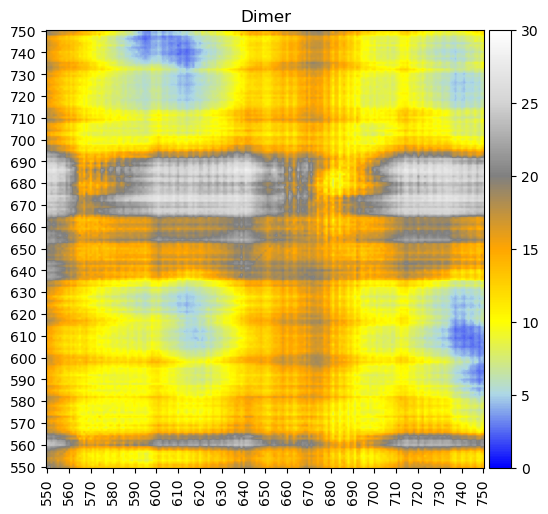

In [7]:


PAEfiles = ["dimer.pkl"]  # Only keep the dimer file
PAE_matrices = []

for PAEfile in PAEfiles:
    fileType = PAEfile.split(".")[-1]
    fileName = PAEfile.split(".")[0]
    if fileType == "pkl":
        results = AlphaFoldPickle(PAEfile, None)
    else:
        raise TypeError("Expected file of type .pkl. Check the extensions of uploaded PAE files match one of these and rerun the upload step.")
    PAE_matrices.append(results.PAE)

# Define the parts of the matrix you want to select
start_y = 1325
end_y = 1526
start_x = 550
end_x = 751

# Select a part of the matrix
PAE_part = PAE_matrices[0][start_x:end_x, start_y:end_y]

colors = ["blue", "lightblue", "yellow", "orange", "grey", "lightgrey", "white"]
# Define custom colors and values
values = [0, 5, 10, 15, 20, 25, 30]

# Normalize the values to range between 0 and 1
normalized_values = [v / 30 for v in values]
colormap = mcolors.LinearSegmentedColormap.from_list("", list(zip(normalized_values, colors)))

fig, axs = plt.subplots(1, 1, figsize=(6, 6))  # Only create one subplot
img = axs.imshow(PAE_part, cmap=colormap , vmin=0, vmax=30, origin='lower')
axs.set_title('Dimer')
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax)

# Adjust the xticks and yticks to match the corresponding residue numbers
# Adjust the xticks and yticks to match the corresponding residue numbers
ticks = np.arange(0, end_x-start_x, 10)  # Set ticks for every 5 residues
axs.set_xticks(ticks)
axs.set_yticks(ticks)
axs.set_xticklabels(np.arange(start_x, end_x, 10),rotation=90)
axs.set_yticklabels(np.arange(start_y-775, end_y-775, 10))

plt.savefig('inter.png',dpi=300)

plt.show()
